# Network analysis CCLAMP

In [1]:
#import packages
import pandas as pd
import numpy as np
import networkx as nx

In [2]:
# Read metadata file with the authors
metadata_df = pd.read_csv("C-CLAMP_metadata_gender.txt", sep="\t", encoding='utf-8')

# Create list of authors

In [3]:
# Create list of all the authors
import re
from itertools import chain

# Use str.split to split the strings and explode to create separate rows
df_cleaned = metadata_df['Author'].str.split(';', expand=True).stack()

# Reset index to clean up
df_cleaned = df_cleaned.reset_index(drop=True)

# Drop missing values
df_cleaned = df_cleaned.dropna()

# Remove duplicates
df_cleaned = df_cleaned.drop_duplicates()

# Sort the values
df_cleaned = df_cleaned.sort_values().reset_index(drop=True)

# Create a new DataFrame for the authors
Author_df = pd.DataFrame({'Author': df_cleaned})

print(Author_df)

                      Author
0             't Haakstertje
1                   A. Aerts
2           A. Agnes Sneller
3                 A. Alberts
4                    A. Ampe
...                      ...
10519           van der Veur
10520    zuster Maria Jozefa
10521            Ágnes Roboz
10522  Émile O.J.J.G. Lousse
10523        Émile Verhaeren

[10524 rows x 1 columns]


In [4]:
# save author list
Author_df.to_csv("author_list.txt", index=False, sep='\t', encoding='utf-8')

In [5]:
# make list of all authors and their birth dates

# Select Author and DOB
metadata = metadata_df[['Author', 'DOB']]

# Flatten the dataframe
flattened_data = []

for index, row in metadata.iterrows():
    authors = str(row['Author']).split('; ')
    dobs = str(row['DOB']).split('; ')
    
    for author, dob in zip(authors, dobs):
        flattened_data.append({'Author': author, 'DOB': dob})

flattened_df = pd.DataFrame(flattened_data)

# Replace 'NA' or 'nan' with NaN
flattened_df.replace(['NA', 'nan'], np.nan, inplace=True)

# Remove duplicate rows
authors_dob_df = flattened_df.drop_duplicates()

# Display the flattened dataframe
print(authors_dob_df)


                   Author              DOB
0                     NaN              NaN
1            Jan Engelman      7 juni 1900
2             Willem Maas    28 april 1897
3            Joep Nicolas   6 oktober 1897
5           Albert Helman  7 november 1903
...                   ...              ...
62928        A. De Geyter       20ste eeuw
62929            J. Hoing       20ste eeuw
62930       Flor Kielbaey       20ste eeuw
62931  Hendrik Imberechts    13 april 1922
62932            H. Aerts       20ste eeuw

[8798 rows x 2 columns]


In [6]:
authors_dob_df.to_csv("author_DOB_list.txt", index=False, sep='\t', encoding='utf-8')
authors_dob_df.head(20)

,Author,DOB
0,NaN,NaN
1,Jan Engelman,7 juni 1900
2,Willem Maas,28 april 1897
3,Joep Nicolas,6 oktober 1897
5,Albert Helman,7 november 1903
6,Willem Nieuwenhuis,1886
7,Karel van den Oever,19 november 1879
9,Wies Moens,28 januari 1898
10,Eduard A. Serrarens,27 december 1895
11,Henk Kuitenbrouwer,20 november 1903


# Read files and extract all mentions of authors

In [4]:
# read file and extract all mentions of authors
import re

def find_author_mentions(file_name, full_names_df):
    """
    Finds mentions of authors in a text file.

    Args:
        file_name (str): The name of the file.
        full_names_df (pd.DataFrame): DataFrame with full names.
        last_names_df (pd.DataFrame): DataFrame with last names.

    Returns:
        list: List of author mentions found in the text.
    """
    # read file
    with open(file_name, 'r', encoding='utf-8') as file:
        text_content = file.read()
    
    # extract mentions
    author_mentions = []
    
    full_name_column = full_names_df.columns[0]
    
    for index, row in full_names_df.iterrows():
        full_name = row[full_name_column]
        if full_name in text_content:
            author_mentions.append(full_name)
    
    # clean the mentions
    author_mentions = list(set(author_mentions))
    
    # return the mentions
    return author_mentions



In [5]:
# Exract all the mentions from the whole corpus
from tqdm import tqdm
import os

# Create an empty DataFrame to store mentions
mentions_df = pd.DataFrame()

# Filter files with authors
files_with_authors = metadata_df[metadata_df['Author'].notna()]

# Define the total number of iterations (filtered files)
total_iterations = len(files_with_authors)

# Get the current working directory
current_directory = os.getcwd()

# Define the directory path where the files are located (relative to the script)
directory_path = os.path.join(current_directory, 'corpus')

# Define the output file path
output_file = 'mentions_output.txt'

# Loop over each file in the corpus with progress bar
for index, row in tqdm(files_with_authors.iterrows(), total=total_iterations, desc="Processing Files"):
    file_name = row['File']
    file_path = os.path.join(directory_path, f'{file_name}.txt')  # Construct full file path
    if os.path.exists(file_path):  # Check if the file exists
        authors = find_author_mentions(file_path, Author_df)
        if authors:
            # Put mentions into a DataFrame
            m = {'File': file_name, 'Mentions': authors}
            temp_df = pd.DataFrame(m)
            mentions_df = pd.concat([mentions_df, temp_df], ignore_index=True)

# Print the final DataFrame
print(mentions_df)

# Write the mentions DataFrame to a .txt file
mentions_df.to_csv(output_file, index=False, sep='\t', encoding='utf-8')

Processing Files: 100%|████████████████████████████████████████████████████████| 40048/40048 [9:35:31<00:00,  1.16it/s]


               File             Mentions
0        GEM_1925_3         Joep Nicolas
1        GEM_1925_5   Hendrik Andriessen
2        GEM_1925_6   Willem Nieuwenhuis
3        GEM_1925_7  Karel van den Oever
4        GEM_1925_9           Wies Moens
...             ...                  ...
138371  STR_1947_99             Henricus
138372  STR_1947_99           M. Huybens
138373  STR_1947_99             R. Leijs
138374  STR_1947_99                 Léon
138375  STR_1947_99             Horatius

[138376 rows x 2 columns]


# Add mentions to authors

In [7]:
# read all mentions
all_mentions_df = pd.read_csv("mentions_output.txt", sep="\t", encoding='utf-8')
print(all_mentions_df)

               File             Mentions
0        GEM_1925_3         Joep Nicolas
1        GEM_1925_5   Hendrik Andriessen
2        GEM_1925_6   Willem Nieuwenhuis
3        GEM_1925_7  Karel van den Oever
4        GEM_1925_9           Wies Moens
...             ...                  ...
138371  STR_1947_99             Henricus
138372  STR_1947_99           M. Huybens
138373  STR_1947_99             R. Leijs
138374  STR_1947_99                 Léon
138375  STR_1947_99             Horatius

[138376 rows x 2 columns]


In [8]:
# Merge all_mentions_df and metadata_df
mentions_and_authors_df = pd.merge(all_mentions_df, metadata_df, on='File', how='inner')  # 'inner' means keep only common rows

print(mentions_and_authors_df)

# save output
mentions_and_authors_df.to_csv("mentions_and_authors.txt", index=False, sep='\t', encoding='utf-8')

               File             Mentions  Year  \
0        GEM_1925_3         Joep Nicolas  1925   
1        GEM_1925_5   Hendrik Andriessen  1925   
2        GEM_1925_6   Willem Nieuwenhuis  1925   
3        GEM_1925_7  Karel van den Oever  1925   
4        GEM_1925_9           Wies Moens  1925   
...             ...                  ...   ...   
138371  STR_1947_99             Henricus  1947   
138372  STR_1947_99           M. Huybens  1947   
138373  STR_1947_99             R. Leijs  1947   
138374  STR_1947_99                 Léon  1947   
138375  STR_1947_99             Horatius  1947   

                                                    Title  \
0       Sint Maartensavond Bij een linoleumsnede van J...   
1       Is de nieuwe meerstemmige kerkmuziek in Nederl...   
2                 Dagelijksch brood en dagelijksch leven.   
3                                     In Memoriam Fratris   
4                                                 Koraal.   
...                              

# Create network

In [9]:
# create coauthor x coauthor pairs

from itertools import combinations

# Create coauthors_df
coauthors_df = metadata_df[['Author']].copy()

# Filter out rows with only 1 author
df_filtered = coauthors_df[coauthors_df['Author'].str.count(';') > 0]

# Function to get combinations of authors
def get_author_combinations(row):
    authors = row['Author'].split('; ')
    return list(combinations(authors, 2))  # Change the number inside combinations() for different combinations

# Apply the function to each row: this will create a new column 'Author Combinations' with a list of combinations for each row
df_filtered['Author Combinations'] = df_filtered.apply(get_author_combinations, axis=1)

# Create an empty list to store the combinations
combinations_list = []

# Iterate through each row and extract combinations
for _, row in df_filtered.iterrows():
    combinations_list.extend(row['Author Combinations'])

coauthor_combinations_df = pd.DataFrame(combinations_list, columns=['Target', 'Source'])
coauthor_combinations_reverse_df = pd.DataFrame(combinations_list, columns=['Source', 'Target'])
print(coauthor_combinations_df)
print(coauthor_combinations_reverse_df)


C:\Users\u0149275\AppData\Local\Temp\ipykernel_14728\448864839.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Author Combinations'] = df_filtered.apply(get_author_combinations, axis=1)


                   Target              Source
0            Jan Engelman         Willem Maas
1      Henk Kuitenbrouwer           Jan Bruna
2            Jan Engelman         Willem Maas
3            Jan Engelman        Albert Kuyle
4            Jan Engelman           Jan Bruna
...                   ...                 ...
30957            J. Hoing  Hendrik Imberechts
30958            J. Hoing            H. Aerts
30959       Flor Kielbaey  Hendrik Imberechts
30960       Flor Kielbaey            H. Aerts
30961  Hendrik Imberechts            H. Aerts

[30962 rows x 2 columns]
                   Source              Target
0            Jan Engelman         Willem Maas
1      Henk Kuitenbrouwer           Jan Bruna
2            Jan Engelman         Willem Maas
3            Jan Engelman        Albert Kuyle
4            Jan Engelman           Jan Bruna
...                   ...                 ...
30957            J. Hoing  Hendrik Imberechts
30958            J. Hoing            H. Aerts
30959   

In [10]:
# Create mention x author pairs 

# Splitting authors column
authors_split = mentions_and_authors_df['Author'].str.split('; ', expand=True).stack()

# Dropping the original authors column
mentions_and_authors_df.drop('Author', axis=1, inplace=True)

# Restoring the index alignment
authors_split.index = authors_split.index.droplevel(1)

# Combining the DataFrame with split authors and original DataFrame
mentions_and_authors_df = mentions_and_authors_df.join(authors_split.rename('Author'))

print(mentions_and_authors_df)


               File             Mentions  Year  \
0        GEM_1925_3         Joep Nicolas  1925   
1        GEM_1925_5   Hendrik Andriessen  1925   
2        GEM_1925_6   Willem Nieuwenhuis  1925   
3        GEM_1925_7  Karel van den Oever  1925   
4        GEM_1925_9           Wies Moens  1925   
...             ...                  ...   ...   
138375  STR_1947_99             Horatius  1947   
138375  STR_1947_99             Horatius  1947   
138375  STR_1947_99             Horatius  1947   
138375  STR_1947_99             Horatius  1947   
138375  STR_1947_99             Horatius  1947   

                                                    Title  \
0       Sint Maartensavond Bij een linoleumsnede van J...   
1       Is de nieuwe meerstemmige kerkmuziek in Nederl...   
2                 Dagelijksch brood en dagelijksch leven.   
3                                     In Memoriam Fratris   
4                                                 Koraal.   
...                              

In [11]:
# create dataframe pairs_df with only the authors and the mentions
pairs_df = mentions_and_authors_df[['Mentions', 'Author']]

# Rename to target and source
pairs_df = pairs_df.rename(columns={'Mentions': 'Target', 'Author': 'Source'})

# Remove rows where mention and author have the same value
pairs_df = pairs_df[pairs_df['Source'] != pairs_df['Target']]

# Add the coauthors
pairs_df = pd.concat([pairs_df, coauthor_combinations_df], ignore_index=True)
pairs_df = pd.concat([pairs_df, coauthor_combinations_reverse_df], ignore_index=True)

# Initialize weights based on direction
pairs_df['Weight'] = 1

# Increment weights for mentions as targets
pairs_df.loc[pairs_df['Source'] == pairs_df['Target'], 'Weight'] += 1

# Identify duplications
pairs_df = pairs_df.groupby(['Target', 'Source'], sort=False, as_index=False)['Weight'].sum()

# exclude pairs that occur less than 5 times
pairs_df = pairs_df[pairs_df['Weight'] >= 5]

pairs_df.head(50)

,Target,Source,Weight
1,Henri Bruning,Henk Kuitenbrouwer,12
5,Albert Kuyle,Henk Kuitenbrouwer,37
7,Albe,Henk Kuitenbrouwer,25
29,Dirk Coster,Henk Kuitenbrouwer,11
31,Dirk Coster,Jan Engelman,13
40,Erich Wichman,Jan Engelman,6
46,Willem Pijper,Jan Engelman,5
47,Albe,Jan Engelman,27
50,Henri Bruning,Jan Engelman,6
55,Just Havelaar,Jan Engelman,5


# Add birth dates of the targets to the dataframe

In [12]:
authors_dob_df = pd.read_csv("author_DOB_list.txt", sep="\t", encoding='utf-8')

# Merge pairs_df with the day of birth column of authors_DOB_final_df
merged_pairs_df = pd.merge(pairs_df, authors_dob_df, left_on='Target', right_on='Author', how='left')

merged_pairs_df

# Display the result
print(merged_pairs_df)


                       Target                       Source  Weight  \
0               Henri Bruning           Henk Kuitenbrouwer      12   
1                Albert Kuyle           Henk Kuitenbrouwer      37   
2                        Albe           Henk Kuitenbrouwer      25   
3                 Dirk Coster           Henk Kuitenbrouwer      11   
4                 Dirk Coster                 Jan Engelman      13   
...                       ...                          ...     ...   
7967             Louis Bruyns              Albert Deblaere       5   
7968  K. du Bois de Vroylande               Louis Sterkens       5   
7969           Jos. Burvenich           E.J. Vandenbussche       5   
7970         Jozef Andriessen            Emiel Jan Janssen       5   
7971  K. du Bois de Vroylande  Paul Maria Jozef de Meester       6   

                       Author               DOB  
0               Henri Bruning      10 juli 1900  
1                Albert Kuyle  17 februari 1904  
2        

# Filter the network by DOB

In [13]:
import re

# Identify rows to drop
rows_to_drop = []

# Throw out targets born before 1700
for index, row in merged_pairs_df.iterrows():
    dob_value = row['DOB']
    
    if pd.isna(dob_value):
        # Skip rows with NaN values in 'DOB'
        continue
    
    if 'eeuw' in dob_value:
        # Handle cases with 'eeuw' (century) in DOB
        century_str = dob_value.split()[0]
        if century_str[:-2].isdigit():  # Check if the part before 'de' is numeric
            century = int(century_str[:-2])
            if century >= 18:  # Assuming 18th century and later
                # Keep the row
                continue
    elif 'v.Chr.' in dob_value:
        # Handle cases with 'ca.' (circa) or 'v.Chr.' (before Christ) in DOB
        rows_to_drop.append(index)
    else:
        # Extract 4-digit years using regular expression
        year_match = re.search(r'(\d{4})', dob_value)
        if year_match:
            year = int(year_match.group())
            if year >= 1700:
                # Keep the row
                continue

        # Add row index to drop list
        rows_to_drop.append(index)

# Drop rows using the drop method outside of the loop
merged_pairs_df = merged_pairs_df.drop(rows_to_drop).reset_index(drop=True)


# Extra filtering step for specific authors

In [30]:
# Throw out: Leopold, Peeters, Hubert, Henricus, Ian, Homerus, Horatius and Léon

filter_list = ["Leopold", "Peeters", "Hubert", "Henricus", "Ian", "Homerus", "Horatius", "Léon", "Constantijn"]

# Create a boolean mask for rows to keep
mask = ~(merged_pairs_df['Target'].isin(filter_list) | merged_pairs_df['Source'].isin(filter_list))

# Apply the mask to keep only the rows that don't match the filter_list
filtered_df = merged_pairs_df[mask]

filtered_df.head(50)


,Target,Source,Weight,Author,DOB
0,Henri Bruning,Henk Kuitenbrouwer,12,Henri Bruning,10 juli 1900
1,Albert Kuyle,Henk Kuitenbrouwer,37,Albert Kuyle,17 februari 1904
2,Albe,Henk Kuitenbrouwer,25,Albe,8 juni 1902
3,Dirk Coster,Henk Kuitenbrouwer,11,Dirk Coster,7 juli 1887
4,Dirk Coster,Jan Engelman,13,Dirk Coster,7 juli 1887
5,Erich Wichman,Jan Engelman,6,Erich Wichman,11 augustus 1890
6,Willem Pijper,Jan Engelman,5,Willem Pijper,8 september 1894
7,Albe,Jan Engelman,27,Albe,8 juni 1902
8,Henri Bruning,Jan Engelman,6,Henri Bruning,10 juli 1900
9,Just Havelaar,Jan Engelman,5,Just Havelaar,12 februari 1880


# Save the network

In [31]:
# Write the network to a .txt file
filtered_df.to_csv("CCLAMP_Directed_Network.txt", index=False, sep='\t', encoding='utf-8')

# Read network

In [32]:
# read the network
network = pd.read_csv("CCLAMP_Directed_Network.txt", sep="\t", encoding='utf-8')
network.head(10)

,Target,Source,Weight,Author,DOB
0,Henri Bruning,Henk Kuitenbrouwer,12,Henri Bruning,10 juli 1900
1,Albert Kuyle,Henk Kuitenbrouwer,37,Albert Kuyle,17 februari 1904
2,Albe,Henk Kuitenbrouwer,25,Albe,8 juni 1902
3,Dirk Coster,Henk Kuitenbrouwer,11,Dirk Coster,7 juli 1887
4,Dirk Coster,Jan Engelman,13,Dirk Coster,7 juli 1887
5,Erich Wichman,Jan Engelman,6,Erich Wichman,11 augustus 1890
6,Willem Pijper,Jan Engelman,5,Willem Pijper,8 september 1894
7,Albe,Jan Engelman,27,Albe,8 juni 1902
8,Henri Bruning,Jan Engelman,6,Henri Bruning,10 juli 1900
9,Just Havelaar,Jan Engelman,5,Just Havelaar,12 februari 1880


In [33]:
# Create a weighted graph
G = nx.from_pandas_edgelist(network, 
                            source = 'Source', 
                            target = 'Target', 
                            edge_attr = 'Weight',
                            create_using = nx.DiGraph())
print(G)

DiGraph with 1629 nodes and 7247 edges


# Centrality measures

<Axes: >

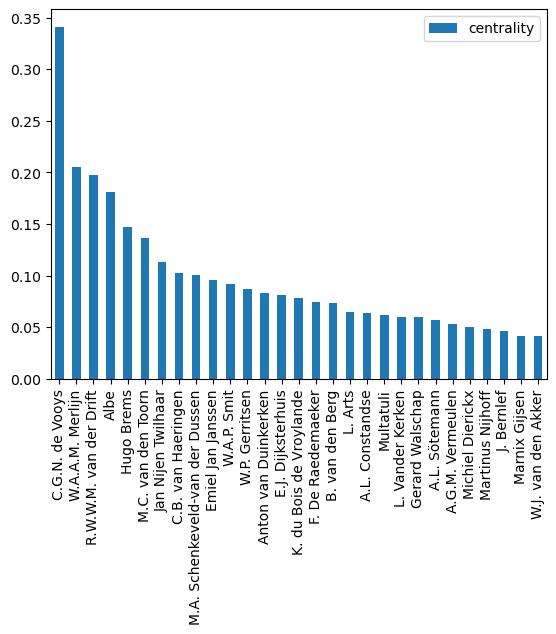

In [34]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 30 nodes
degree_df.sort_values('centrality', ascending=False)[0:29].plot(kind="bar")

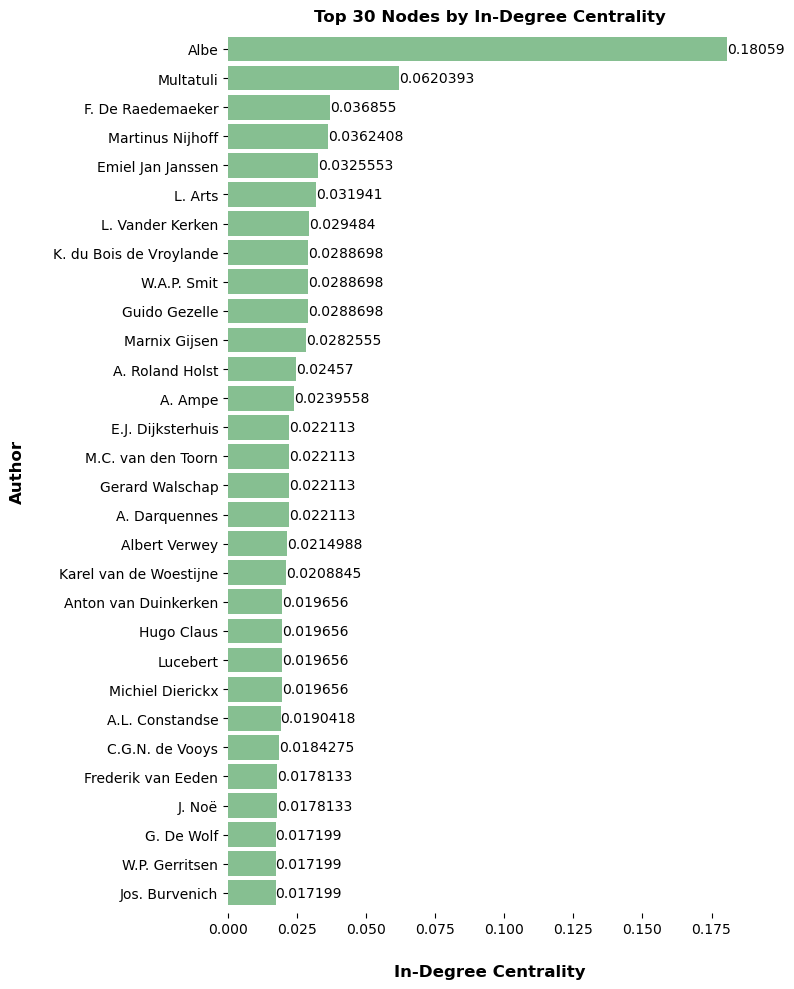

In [42]:
# In-Degree Centrality Calculation
in_degree_dict = nx.in_degree_centrality(G)
in_degree_df = pd.DataFrame.from_dict(in_degree_dict, orient='index', columns=['centrality'])
top_in_degree_nodes = in_degree_df.sort_values('centrality', ascending=False).head(30)

import matplotlib.pyplot as plt

# Plot Top 30 Nodes by In-Degree Centrality
ax = top_in_degree_nodes.plot(kind="barh", figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Labels and Title
ax.set_xlabel("In-Degree Centrality", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Author", labelpad=20, weight='bold', size=12)
ax.set_title("Top 30 Nodes by In-Degree Centrality", size=12, weight='bold')

ax.invert_yaxis()  # Reverse the y-axis
ax.bar_label(ax.containers[0])  # Add labels to the bars
plt.tight_layout()  # Adjust layout
ax.legend().set_visible(False)

plt.show()


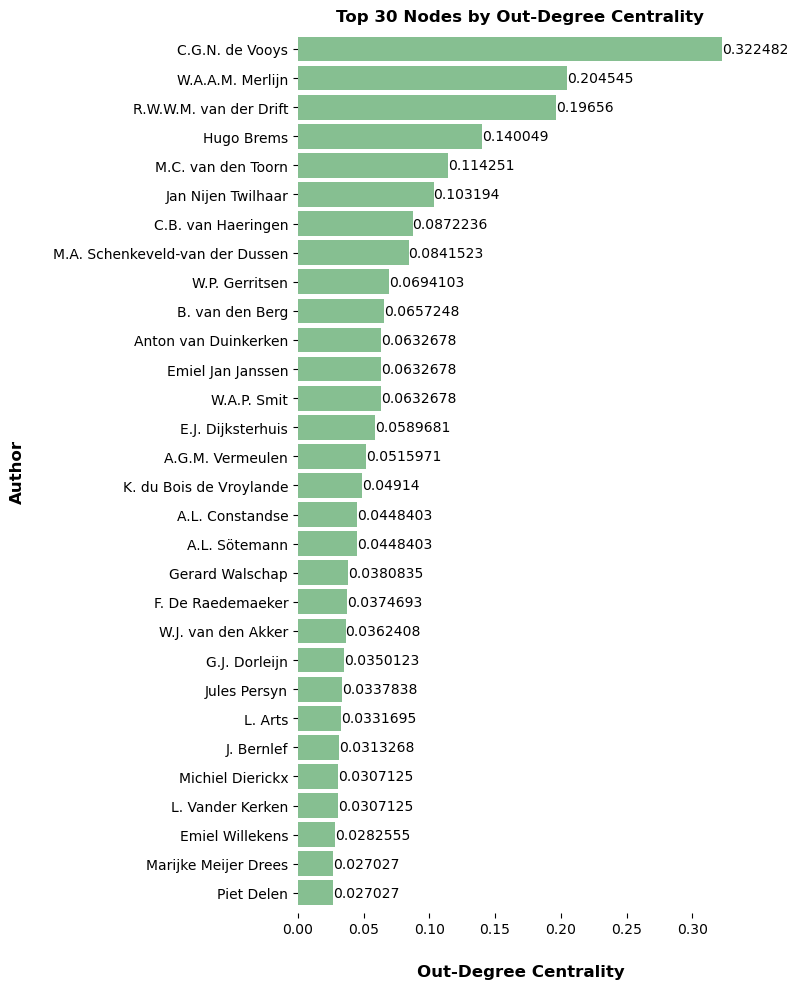

In [43]:
# Out-Degree Centrality Calculation
out_degree_dict = nx.out_degree_centrality(G)
out_degree_df = pd.DataFrame.from_dict(out_degree_dict, orient='index', columns=['centrality'])
top_out_degree_nodes = out_degree_df.sort_values('centrality', ascending=False).head(30)

import matplotlib.pyplot as plt

# Plot Top 30 Nodes by Out-Degree Centrality
ax = top_out_degree_nodes.plot(kind="barh", figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Labels and Title
ax.set_xlabel("Out-Degree Centrality", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Author", labelpad=20, weight='bold', size=12)
ax.set_title("Top 30 Nodes by Out-Degree Centrality", size=12, weight='bold')

ax.invert_yaxis()  # Reverse the y-axis
ax.bar_label(ax.containers[0])  # Add labels to the bars
plt.tight_layout()  # Adjust layout
ax.legend().set_visible(False)

plt.show()


<Axes: >

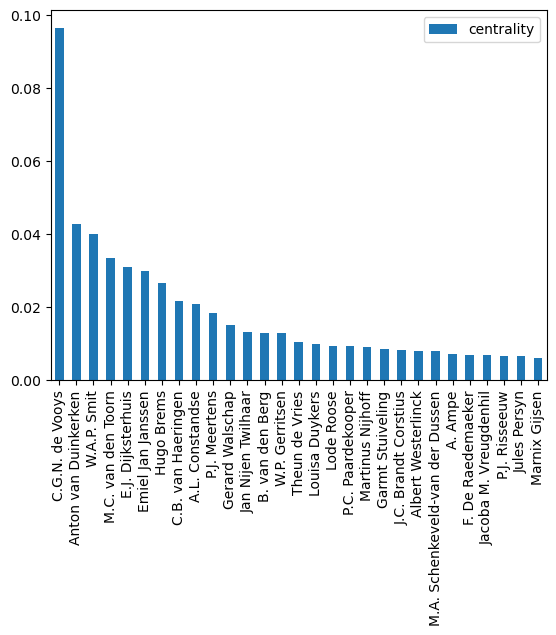

In [35]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 30 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:29].plot(kind="bar")

<Axes: >

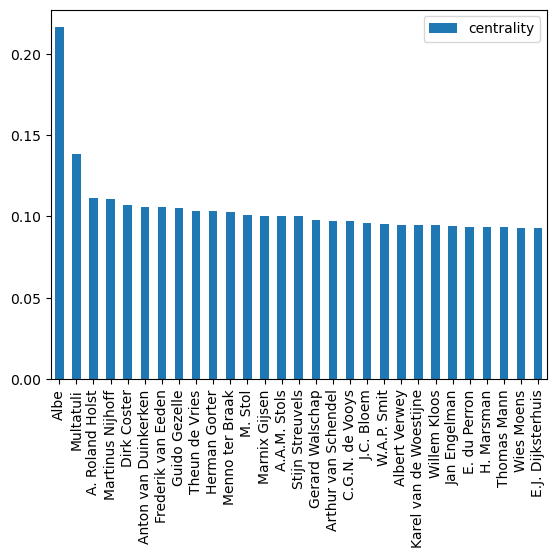

In [36]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 30 nodes
closeness_df.sort_values('centrality', ascending=False)[0:29].plot(kind="bar")

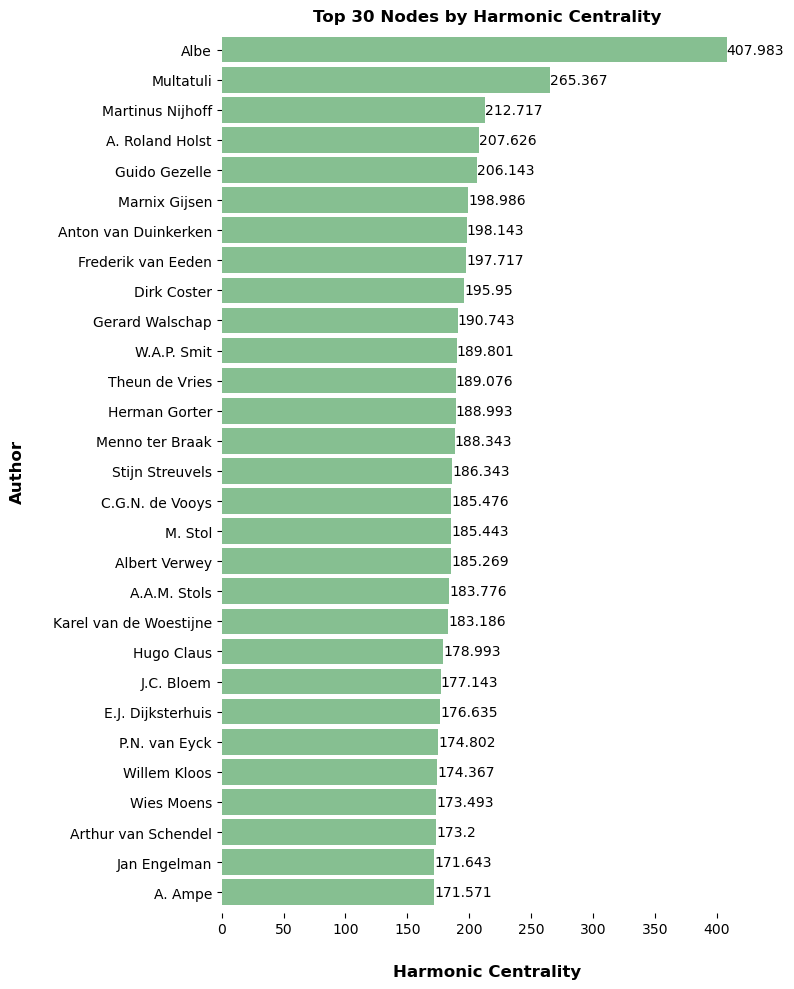

In [37]:
# Harmonic centrality
harmonic_dict = nx.harmonic_centrality(G)
harmonic_df = pd.DataFrame.from_dict(harmonic_dict, orient='index', columns=['centrality'])
x = harmonic_df.sort_values('centrality', ascending=False)[0:29]

import matplotlib.pyplot as plt

# Plot top 30 nodes
ax = x.plot(kind="barh", figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Labels and title
ax.set_xlabel("Harmonic Centrality", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Author", labelpad=20, weight='bold', size=12)
ax.set_title("Top 30 Nodes by Harmonic Centrality", size=12, weight='bold')

ax.invert_yaxis()  # Reverse the y-axis
ax.bar_label(ax.containers[0])  # Add labels to the bars
plt.tight_layout()  # Adjust layout
ax.legend().set_visible(False)

plt.show()


In [38]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, in_degree_dict, 'in_degree_centrality')
nx.set_node_attributes(G, out_degree_dict, 'out_degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')
nx.set_node_attributes(G, harmonic_dict, 'harmonic_centrality')

In [45]:
# Creating DataFrames from the centrality dictionaries
harmonic_df = pd.DataFrame.from_dict(harmonic_dict, orient='index', columns=['Harmonic'])
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['Closeness'])
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['Degree'])
in_degree_df = pd.DataFrame.from_dict(in_degree_dict, orient='index', columns=['In-degree'])
out_degree_df = pd.DataFrame.from_dict(out_degree_dict, orient='index', columns=['Out-degree'])
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['Betweenness'])

# Merging all DataFrames on the "Author" index
centrality_df = harmonic_df.join(closeness_df).join(degree_df).join(betweenness_df).join(in_degree_df).join(out_degree_df)

# Rename the index to "Author"
centrality_df.index.name = 'Author'

# Display the first 10 rows of the merged DataFrame
print(centrality_df.head(10))

# Save the merged DataFrame to a TSV file
centrality_df.to_csv("CCLAMP_Network_Centralities.txt", index=True, sep='\t', encoding='utf-8')

                                Harmonic  Closeness    Degree  Betweenness  \
Author                                                                       
Albert Deblaere               139.641667   0.068685  0.035012     0.000205   
Günter Grass                  112.651984   0.061588  0.002457     0.000000   
Nico van Suchtelen            137.235714   0.076942  0.003686     0.000168   
P.C. Schoonees                128.096429   0.072170  0.001229     0.000000   
Eriek Verpale                  89.110317   0.048237  0.001843     0.000000   
Hendrik Conscience            148.679762   0.080715  0.003686     0.000000   
Hans Heestermans                1.500000   0.000819  0.000614     0.000000   
Albertine Steenhoff-Smulders  131.561905   0.074441  0.001229     0.000000   
Jozef Andriessen              108.052381   0.056797  0.004300     0.000000   
W. van den Ent                138.813095   0.076743  0.001229     0.000000   

                              In-degree  Out-degree  
Author   

# Community detection

In [46]:
import community.community_louvain as community_louvain

# Convert directed graph to undirected
G_undirected = G.to_undirected()

# Create communities
communities = community_louvain.best_partition(G_undirected)

# Print communities
print(communities)

{'Henk Kuitenbrouwer': 5, 'Henri Bruning': 5, 'Albert Kuyle': 5, 'Albe': 1, 'Dirk Coster': 5, 'Jan Engelman': 5, 'Erich Wichman': 5, 'Willem Pijper': 5, 'Just Havelaar': 5, 'Gerard Bruning': 5, 'Joep Nicolas': 5, 'Gerard Brom': 5, 'Bernard Verhoeven': 5, 'Johan de Meester': 5, 'Karel van den Oever': 5, 'Huib Luns': 5, 'Wies Moens': 1, 'Marnix Gijsen': 1, 'Herman Teirlinck': 1, 'Richard Minne': 1, 'J.C. Bloem': 3, 'Albert Helman': 5, 'G.P.M. Knuvelder': 1, 'Frederik van Eeden': 5, 'Menno ter Braak': 5, 'Willem Nieuwenhuis': 5, 'Herman de Man': 5, 'Henriette Roland Holst-van der Schalk': 1, 'Charles Eyck': 5, 'H. Marsman': 5, 'A. den Doolaard': 5, 'Anton van Duinkerken': 5, 'A.A.M. Stols': 9, 'M. Stol': 9, 'Herman Gorter': 5, 'A. Roland Holst': 5, 'Ernest Michel': 5, 'A.M. de Jong': 5, 'Willem Maas': 5, 'Hendrik de Vries': 5, 'Novalis': 5, 'Albert Verwey': 5, 'Antoon Coolen': 5, 'Stijn Streuvels': 1, 'H.E.H. van Loon': 5, 'H. van Loon': 5, 'Sybold van Ravesteyn': 5, 'Karel van de Woestij

In [47]:
# save communities
communities_df = pd.DataFrame.from_dict(communities, orient='index')
communities_df = communities_df.rename_axis('Author').reset_index()
communities_df.columns = ['Author', 'Community']
communities_df.head(10)
communities_df.to_csv("CCLAMP_Network_Communities.txt", index=True, sep='\t', encoding='utf-8')

In [27]:
from pyvis.network import Network
# set communities as a node attribute
nx.set_node_attributes(G, communities, 'group')

# draw graph with communities
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("CCLAMP_communities.html")

CCLAMP_communities.html


# Draw full network

In [28]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor="#222222", font_color="white")

node_degree = dict(G.degree)
      
# setting up node attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show('CCLAMP.html')


CCLAMP.html
